# Allen Common Coordinate Framework (CCF)

This tutorial demonstrates how to model the Allen Mouse Brain Common Coordinate Framework in DataJoint. You'll learn to:

- Model **hierarchical structures** (brain region ontology)
- Use **Part tables** for large-scale voxel data
- Handle **self-referential relationships** (parent regions)
- **Batch insert** large datasets efficiently

## The Allen CCF

The CCF is a 3D reference atlas of the mouse brain, providing:
- Coordinate system with voxel resolution (10, 25, 50, or 100 µm)
- Hierarchical ontology of ~1300 brain regions
- Region boundaries for each voxel

**Reference:**
> Wang Q, Ding SL, Li Y, et al. (2020). The Allen Mouse Brain Common Coordinate Framework: A 3D Reference Atlas. *Cell*, 181(4), 936-953.e20. DOI: [10.1016/j.cell.2020.04.007](https://doi.org/10.1016/j.cell.2020.04.007)

## Data Sources

- **Ontology**: [structure_graph.csv](http://api.brain-map.org/api/v2/data/query.csv?criteria=model::Structure,rma::criteria,[ontology_id$eq1],rma::options[order$eq%27structures.graph_order%27][num_rows$eqall])
- **Volume**: [Allen Institute Archive](http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/)

> **Note**: This tutorial works with the ontology (small CSV). The full 3D volume requires ~100MB+ download.

## Setup

In [1]:
import datajoint as dj
import numpy as np
import pandas as pd
from pathlib import Path
import urllib.request

schema = dj.Schema('tutorial_allen_ccf')

DATA_DIR = Path('./data')
DATA_DIR.mkdir(exist_ok=True)

[2026-02-06 11:45:35] DataJoint 2.1.0 connected to datajoint@127.0.0.1:5432


## Download Brain Region Ontology

The ontology defines the hierarchical structure of brain regions.

In [2]:
ONTOLOGY_URL = (
    "http://api.brain-map.org/api/v2/data/query.csv?"
    "criteria=model::Structure,rma::criteria,[ontology_id$eq1],"
    "rma::options[order$eq%27structures.graph_order%27][num_rows$eqall]"
)
ONTOLOGY_FILE = DATA_DIR / 'allen_structure_graph.csv'

if not ONTOLOGY_FILE.exists():
    print("Downloading Allen brain structure ontology...")
    urllib.request.urlretrieve(ONTOLOGY_URL, ONTOLOGY_FILE)
    print(f"Downloaded to {ONTOLOGY_FILE}")
else:
    print(f"Using cached {ONTOLOGY_FILE}")

ontology = pd.read_csv(ONTOLOGY_FILE)
print(f"Loaded {len(ontology)} brain regions")
ontology.head()

Using cached data/allen_structure_graph.csv
Loaded 1327 brain regions


,id,atlas_id,name,acronym,st_level,ontology_id,hemisphere_id,weight,parent_structure_id,depth,...,graph_order,structure_id_path,color_hex_triplet,neuro_name_structure_id,neuro_name_structure_id_path,failed,sphinx_id,structure_name_facet,failed_facet,safe_name
0,997,-1.0,root,root,0,1,3,8690,NaN,0,...,0,/997/,FFFFFF,NaN,NaN,f,1,385153371,734881840,root
1,8,0.0,Basic cell groups and regions,grey,1,1,3,8690,997.0,1,...,1,/997/8/,BFDAE3,NaN,NaN,f,2,2244697386,734881840,Basic cell groups and regions
2,567,70.0,Cerebrum,CH,2,1,3,8690,8.0,2,...,2,/997/8/567/,B0F0FF,NaN,NaN,f,3,2878815794,734881840,Cerebrum
3,688,85.0,Cerebral cortex,CTX,3,1,3,8690,567.0,3,...,3,/997/8/567/688/,B0FFB8,NaN,NaN,f,4,3591311804,734881840,Cerebral cortex
4,695,86.0,Cortical plate,CTXpl,4,1,3,8690,688.0,4,...,4,/997/8/567/688/695/,70FF70,NaN,NaN,f,5,3945900931,734881840,Cortical plate


## Schema Design

### CCF Master Table

The master table stores atlas metadata. Multiple CCF versions (different resolutions) can coexist.

In [3]:
@schema
class CCF(dj.Manual):
    definition = """
    # Common Coordinate Framework atlas
    ccf_id : int32
    ---
    ccf_version : varchar(64)       # e.g., 'CCFv3'
    ccf_resolution : float32        # voxel resolution in microns
    ccf_description : varchar(255)
    """

### Brain Region Table

Each brain region has an ID, name, acronym, and color code for visualization.

In [4]:
@schema
class BrainRegion(dj.Imported):
    definition = """
    # Brain region from Allen ontology
    -> CCF
    region_id : int32               # Allen structure ID
    ---
    acronym : varchar(32)           # short name (e.g., 'VISp')
    region_name : varchar(255)      # full name
    color_hex : varchar(6)          # hex color code for visualization
    structure_order : int32         # order in hierarchy
    """

    def make(self, key):
        # Load ontology and insert all regions for this CCF
        ontology = pd.read_csv(ONTOLOGY_FILE)
        
        entries = [
            {
                **key,
                'region_id': row['id'],
                'acronym': row['acronym'],
                'region_name': row['safe_name'],
                'color_hex': row['color_hex_triplet'],
                'structure_order': row['graph_order'],
            }
            for _, row in ontology.iterrows()
        ]
        
        self.insert(entries)
        print(f"Inserted {len(entries)} brain regions")

### Hierarchical Parent-Child Relationships

Brain regions form a hierarchy (e.g., Visual Cortex → Primary Visual Area → Layer 1). We model this with a self-referential foreign key.

In [5]:
@schema
class RegionParent(dj.Imported):
    definition = """
    # Hierarchical parent-child relationships
    -> BrainRegion
    ---
    -> BrainRegion.proj(parent_id='region_id')   # parent region
    depth : int16                                 # depth in hierarchy (root=0)
    """

    def make(self, key):
        ontology = pd.read_csv(ONTOLOGY_FILE)
        
        # Build parent mapping
        parent_map = dict(zip(ontology['id'], ontology['parent_structure_id']))
        
        entries = []
        for _, row in ontology.iterrows():
            parent_id = row['parent_structure_id']
            # Skip root (no parent) or if parent not in ontology
            if pd.isna(parent_id):
                parent_id = row['id']  # root points to itself
            
            entries.append({
                **key,
                'region_id': row['id'],
                'parent_id': int(parent_id),
                'depth': row['depth'],
            })
        
        self.insert(entries)
        print(f"Inserted {len(entries)} parent relationships")

### Voxel Data (Optional)

For the full atlas, each voxel maps to a brain region. This is a large table (~10M+ rows for 10µm resolution).

**Design note:** `CCF` is part of the primary key because a voxel's identity depends on which atlas it belongs to. The coordinate `(x=5000, y=3000, z=4000)` exists in every atlas version (10µm, 25µm, etc.) but represents different physical mappings. Without `ccf_id` in the primary key, you couldn't store voxels from multiple atlas resolutions.

> **Note**: We define the schema but don't populate it in this tutorial due to data size.

In [6]:
@schema
class Voxel(dj.Imported):
    definition = """
    # Brain atlas voxels
    -> CCF
    x : int32                       # AP axis (µm)
    y : int32                       # DV axis (µm) 
    z : int32                       # ML axis (µm)
    ---
    -> BrainRegion
    index(y, z)                     # for efficient coronal slice queries
    """
    
    # Note: make() would load NRRD file and insert voxels
    # Skipped in this tutorial due to data size

## View Schema

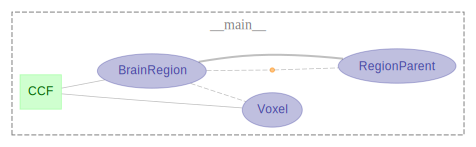

In [7]:
dj.Diagram(schema)

## Populate the Database

In [8]:
# Insert CCF metadata
CCF.insert1(
    {
        'ccf_id': 1,
        'ccf_version': 'CCFv3',
        'ccf_resolution': 25.0,
        'ccf_description': 'Allen Mouse CCF v3 (25µm resolution)'
    },
    skip_duplicates=True
)

CCF()

ccf_id,ccf_version,ccf_resolution,ccf_description
1,CCFv3,25.0,Allen Mouse CCF v3 (25µm resolution)


In [9]:
# Populate brain regions
BrainRegion.populate(display_progress=True)

BrainRegion:   0%|          | 0/1 [00:00<?, ?it/s]

BrainRegion: 100%|██████████| 1/1 [00:00<00:00, 11.49it/s]

Inserted 1327 brain regions


{'success_count': 1, 'error_list': []}

In [10]:
# View sample regions
BrainRegion() & 'region_id < 100'

ccf_id,region_id,acronym,region_name,color_hex,structure_order
1,1,TMv,Tuberomammillary nucleus ventral part,FF4C3E,775
1,2,SSp-m6b,Primary somatosensory area mouth layer 6b,188064,78
1,3,sec,secondary fissure,AAAAAA,1316
1,4,IC,Inferior colliculus,FF7AFF,812
1,6,int,internal capsule,CCCCCC,1201
1,7,PSV,Principal sensory nucleus of the trigeminal,FFAE6F,889
1,8,grey,Basic cell groups and regions,BFDAE3,1
1,9,SSp-tr6a,Primary somatosensory area trunk layer 6a,188064,91
1,10,SCig,Superior colliculus motor related intermediate gray layer,FF90FF,834
1,11,plf,posterolateral fissure,AAAAAA,1317


In [11]:
# Populate parent relationships
RegionParent.populate(display_progress=True)

RegionParent:   0%|          | 0/1327 [00:00<?, ?it/s]

RegionParent:   5%|▍         | 63/1327 [00:00<00:02, 629.87it/s]

Inserted 1327 parent relationships


RegionParent:  19%|█▉        | 249/1327 [00:00<00:00, 1352.91it/s]

RegionParent:  34%|███▎      | 445/1327 [00:00<00:00, 1628.90it/s]

RegionParent:  49%|████▉     | 652/1327 [00:00<00:00, 1802.33it/s]

RegionParent:  64%|██████▍   | 849/1327 [00:00<00:00, 1862.70it/s]

RegionParent:  79%|███████▊  | 1045/1327 [00:00<00:00, 1894.76it/s]

RegionParent:  93%|█████████▎| 1237/1327 [00:00<00:00, 1901.15it/s]

RegionParent: 100%|██████████| 1327/1327 [00:00<00:00, 1779.12it/s]

{'success_count': 1, 'error_list': []}

## Querying the Hierarchy

### Find a Region by Acronym

In [12]:
# Find primary visual cortex
BrainRegion & {'acronym': 'VISp'}

ccf_id,region_id,acronym,region_name,color_hex,structure_order
1,385,VISp,Primary visual area,08858C,185


### Find Children of a Region

In [13]:
# Get VISp region ID
visp = (BrainRegion & {'acronym': 'VISp'}).fetch1()
visp_id = visp['region_id']

# Find all children (direct descendants)
children = BrainRegion * (RegionParent & f'parent_id = {visp_id}' & f'region_id != {visp_id}')
children.proj('acronym', 'region_name')

ccf_id,region_id,acronym,region_name
1,33,VISp6a,Primary visual area layer 6a
1,305,VISp6b,Primary visual area layer 6b
1,593,VISp1,Primary visual area layer 1
1,721,VISp4,Primary visual area layer 4
1,778,VISp5,Primary visual area layer 5
1,821,VISp2/3,Primary visual area layer 2/3


### Find Parent Path (Ancestors)

In [14]:
def get_ancestors(region_acronym, ccf_id=1):
    """Get the path from a region to the root."""
    region = (BrainRegion & {'acronym': region_acronym, 'ccf_id': ccf_id}).fetch1()
    region_id = region['region_id']
    
    path = [region['acronym']]
    
    while True:
        parent_id = (RegionParent & {'ccf_id': ccf_id, 'region_id': region_id}).fetch1('parent_id')
        if parent_id == region_id:  # reached root
            break
        parent = (BrainRegion & {'ccf_id': ccf_id, 'region_id': parent_id}).fetch1()
        path.append(parent['acronym'])
        region_id = parent_id
    
    return ' → '.join(reversed(path))

# Show path from VISp layer 1 to root
print("Path from VISp1 to root:")
print(get_ancestors('VISp1'))

Path from VISp1 to root:
root → grey → CH → CTX → CTXpl → Isocortex → VIS → VISp → VISp1


### Count Regions by Depth

([<matplotlib.axis.XTick at 0x1a2800dd0>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10')])

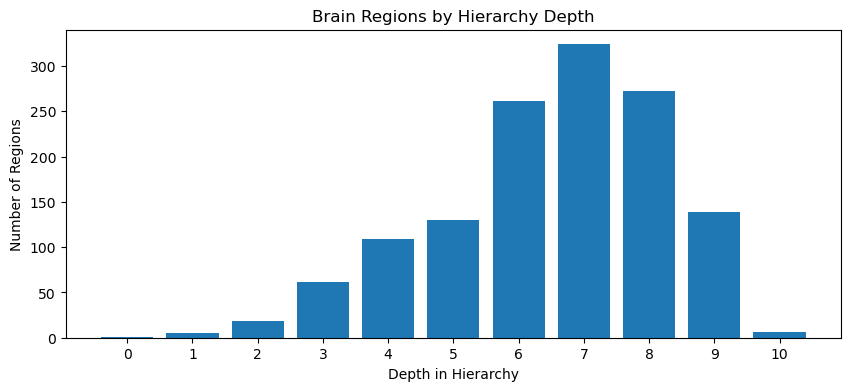

In [15]:
# Aggregate regions by depth in hierarchy
import matplotlib.pyplot as plt

depths = (RegionParent & 'ccf_id = 1').to_arrays('depth')
unique, counts = np.unique(depths, return_counts=True)

plt.figure(figsize=(10, 4))
plt.bar(unique, counts)
plt.xlabel('Depth in Hierarchy')
plt.ylabel('Number of Regions')
plt.title('Brain Regions by Hierarchy Depth')
plt.xticks(unique)

### Search Regions by Name

In [16]:
# Find all visual-related regions
(BrainRegion & "region_name LIKE '%Visual%'").proj('acronym', 'region_name')

ccf_id,region_id,acronym,region_name
1,457,VIS6a,Visual areas layer 6a
1,497,VIS6b,Visual areas layer 6b
1,561,VIS2/3,Visual areas layer 2/3
1,669,VIS,Visual areas
1,801,VIS1,Visual areas layer 1
1,913,VIS4,Visual areas layer 4
1,937,VIS5,Visual areas layer 5


## Extending the Schema

### Recording Locations

A common use case is tracking where electrodes were placed during recordings.

**Design choice:** Here we use `recording_id` alone as the primary key, with `BrainRegion` (which includes `ccf_id`) as a secondary attribute. This means each recording has exactly one canonical atlas registration.

An alternative design would include `ccf_id` in the primary key:
```python
recording_id : int32
-> CCF
---
...
```
This would allow the same recording to be registered to multiple atlas versions (e.g., comparing assignments in CCFv2 vs CCFv3). Choose based on your use case:

| Design | Primary Key | Use Case |
|--------|-------------|----------|
| Single registration | `recording_id` | One canonical atlas per lab |
| Multi-atlas | `(recording_id, ccf_id)` | Compare across atlas versions |

In [17]:
@schema
class RecordingSite(dj.Manual):
    definition = """
    # Recording electrode location
    recording_id : int32
    ---
    ap : float32                    # anterior-posterior (µm from bregma)
    dv : float32                    # dorsal-ventral (µm from brain surface)
    ml : float32                    # medial-lateral (µm from midline)
    -> BrainRegion                  # assigned brain region (includes ccf_id)
    """

# Insert example recording sites
RecordingSite.insert([
    {'recording_id': 1, 'ccf_id': 1, 'ap': -3500, 'dv': 500, 'ml': 2500, 
     'region_id': (BrainRegion & {'acronym': 'VISp'}).fetch1('region_id')},
    {'recording_id': 2, 'ccf_id': 1, 'ap': -1800, 'dv': 1200, 'ml': 1500,
     'region_id': (BrainRegion & {'acronym': 'CA1'}).fetch1('region_id')},
], skip_duplicates=True)

# View recordings with region info
RecordingSite * BrainRegion.proj('acronym', 'region_name')

recording_id,ap,dv,ml,ccf_id,region_id,acronym,region_name
1,-3500.0,500.0,2500.0,1,385,VISp,Primary visual area
2,-1800.0,1200.0,1500.0,1,382,CA1,Field CA1


## Summary

This tutorial demonstrated DataJoint patterns for atlas and ontology data:

| Pattern | Example | Purpose |
|---------|---------|--------|
| **Hierarchical data** | `BrainRegion`, `RegionParent` | Model tree structures |
| **Self-referential FK** | `parent_id → region_id` | Parent-child relationships |
| **Batch insert** | `self.insert(entries)` | Efficient bulk loading |
| **Secondary index** | `index(y, z)` | Optimize spatial queries |
| **Linked tables** | `RecordingSite → BrainRegion` | Reference atlas in experiments |

### Loading Full Atlas Data

To load the complete 3D volume:

1. Download NRRD file from [Allen Institute](http://download.alleninstitute.org/informatics-archive/current-release/mouse_ccf/annotation/ccf_2017/)
2. Install `pynrrd`: `pip install pynrrd`
3. Load and insert voxels (see [Element Electrode Localization](https://github.com/datajoint/element-electrode-localization))

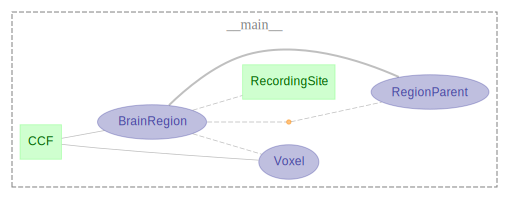

In [18]:
# Final schema diagram
dj.Diagram(schema)

In [19]:
# Cleanup
schema.drop(prompt=False)